In [370]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiplicativeLR
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from tqdm import *
import seaborn as sns

## **The dataset is shown below:**

In [371]:
data_df = pd.read_csv('../data/CreditPrediction.csv')
# removing duplicated datas
data_no_dup = data_df.drop_duplicates() 
# data_no_dup = data_no_dup.fillna(0)
# data_no_dup = pd.get_dummies(data_no_dup, columns=['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category'], drop_first=True, )

data_no_dup

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Unnamed: 19
0,768805383,45.0,M,3,High School,Married,$60K - $80K,Blue,39.0,5.0,1,3,12691.0,777,1.335,1144,42,1.625,0.061,NaN
1,818770008,49.0,F,5,Graduate,NaN,Less than $40K,Blue,44.0,6.0,1,2,8256.0,864,1.541,1291,33,3.714,0.105,NaN
2,713982108,51.0,M,3,Graduate,Married,$80K - $120K,Blue,36.0,4.0,1,0,3418.0,0,2.594,1887,20,2.333,0.000,NaN
3,769911858,40.0,F,4,High School,NaN,Less than $40K,Blue,34.0,3.0,4,1,3313.0,2517,1.405,1171,20,2.333,0.760,NaN
4,709106358,40.0,M,3,Uneducated,Married,$60K - $80K,NaN,21.0,5.0,1,0,4716.0,0,2.175,816,28,2.500,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10128,712110333,37.0,F,3,High School,NaN,Unknown,NaN,18.0,4.0,1,3,2179.0,0,0.725,2568,48,0.297,0.000,NaN
10134,712674183,53.0,M,2,College,NaN,$40K - $60K,Blue,33.0,3.0,3,1,4065.0,2180,0.321,1271,36,0.200,0.536,NaN
10135,718421808,56.0,F,2,Uneducated,Married,Unknown,Blue,43.0,6.0,3,2,3068.0,1765,0.853,4611,73,0.698,0.575,NaN
10136,809452383,37.0,F,2,Graduate,Married,Less than $40K,NaN,32.0,6.0,1,3,1438.3,0,0.707,4733,89,0.816,0.000,NaN


Text(0.5, 0, 'Sample')

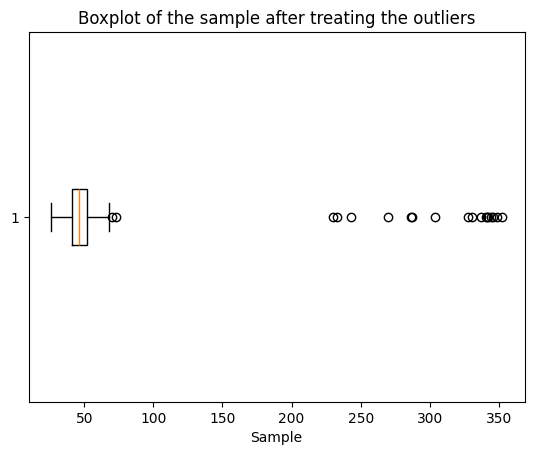

In [372]:
plt.boxplot(data_no_dup['Customer_Age'], vert=False)
plt.title("Boxplot of the sample after treating the outliers")
plt.xlabel("Sample")

## **Handling Outliers:**

In [373]:
def detect_outliers_iqr(data_col):

    median = np.median(data_col)

    outliers = []
    data_sorted = sorted(data_col)
    q1 = np.percentile(data_sorted, 25)
    q3 = np.percentile(data_sorted, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for d in data_sorted: 
        if (d<lwr_bound or d>upr_bound):
            index = data_col.loc[data_col == d].index
            for i in index:
                data_col[i] = median
            outliers.append(i)
    return outliers# Driver code


for col in data_no_dup:
    if col not in (data_no_dup.select_dtypes(include='object').columns):
        sample_outliers = detect_outliers_iqr(data_no_dup[col])
        print(f"COL: {col} || Outliers from IQR method: ", sample_outliers)

COL: CLIENTNUM || Outliers from IQR method:  []
COL: Customer_Age || Outliers from IQR method:  [254, 251, 4151, 4725, 4776, 4978, 7263, 7732, 9907, 7795, 10047, 2902, 9187, 8125, 3626, 7007, 8506, 2604, 9438]
COL: Dependent_count || Outliers from IQR method:  []
COL: Months_on_book || Outliers from IQR method:  []
COL: Total_Relationship_Count || Outliers from IQR method:  []
COL: Months_Inactive_12_mon || Outliers from IQR method:  [9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 9633, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10049, 10

/tmp/ipykernel_5338/3482863993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = median
/tmp/ipykernel_5338/3482863993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = median
/tmp/ipykernel_5338/3482863993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = median
/tmp/ipykernel_5338/3482863993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

COL: Contacts_Count_12_mon || Outliers from IQR method:  [10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 10120, 1012

/tmp/ipykernel_5338/3482863993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = median
/tmp/ipykernel_5338/3482863993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = median
/tmp/ipykernel_5338/3482863993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = median
/tmp/ipykernel_5338/3482863993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

COL: Credit_Limit || Outliers from IQR method:  [2347, 3577, 2671, 9524, 3742, 4330, 6732, 9730, 63, 6502, 1289, 3069, 10029, 10029, 10029, 10029, 10029, 10029, 10029, 10029, 10029, 10029, 10029, 10029, 896, 1514, 9725, 3641, 5864, 4662, 2431, 3433, 9423, 3359, 118, 3520, 7565, 7565, 9758, 9104, 3163, 9205, 9205, 8544, 8988, 4449, 1815, 4296, 74, 1459, 8564, 262, 209, 8438, 2660, 2269, 7550, 491, 421, 8913, 5985, 3716, 8980, 3771, 5265, 1027, 378, 1461, 2985, 1924, 4034, 471, 5009, 3362, 8704, 2038, 8621, 652, 1641, 9543, 397, 6945, 571, 946, 9567, 2618, 9185, 4225, 2355, 3200, 8637, 8325, 2022, 3933, 2152, 4452, 1293, 5304, 3605, 8632, 9918, 793, 3994, 1438, 2656, 9914, 7243, 4536, 3101, 6515, 4691, 69, 8193, 9175, 9353, 3949, 2289, 2432, 9174, 2358, 3147, 8166, 9052, 735, 6395, 1341, 1101, 4982, 9020, 8995, 1868, 9000, 4145, 3750, 5492, 2979, 1080, 2440, 8735, 2744, 4320, 5113, 4384, 9951, 2469, 3679, 2356, 4036, 5276, 2997, 4695, 5164, 4213, 453, 2878, 2762, 3893, 5302, 4912, 2528, 

/tmp/ipykernel_5338/3482863993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = median
/tmp/ipykernel_5338/3482863993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = median
/tmp/ipykernel_5338/3482863993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = median
/tmp/ipykernel_5338/3482863993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

COL: Total_Trans_Amt || Outliers from IQR method:  [8914, 9959, 9231, 9093, 9921, 9028, 9327, 9327, 8794, 9156, 9156, 9007, 8949, 9471, 9898, 9817, 9022, 9333, 9917, 9013, 9019, 10051, 8975, 8591, 9062, 9784, 9860, 9075, 9058, 9025, 9578, 9578, 10040, 10021, 10123, 9856, 9856, 9115, 9113, 9088, 8734, 8918, 9095, 10065, 8708, 9833, 9072, 8960, 9114, 9558, 9029, 9119, 8670, 8977, 8973, 9048, 9837, 9094, 9094, 9951, 8941, 9464, 9056, 9569, 9070, 9126, 10107, 9996, 9107, 10050, 8650, 9041, 9665, 9672, 10034, 9064, 8907, 9091, 10092, 9444, 9037, 9883, 9883, 9069, 9977, 9124, 9767, 9049, 10047, 9725, 9076, 9492, 8942, 9632, 9612, 9461, 9073, 9409, 9050, 9565, 9337, 9639, 9916, 9669, 10013, 9625, 10023, 9040, 9457, 9795, 9211, 9285, 8847, 10112, 10112, 9132, 9985, 9313, 10020, 8993, 9623, 9082, 10006, 9823, 9926, 10071, 9740, 9118, 9123, 9756, 10016, 10055, 10018, 9850, 10064, 9797, 9695, 9975, 10098, 9877, 9968, 10105, 9458, 9822, 10113, 10124, 10126, 10118, 10108, 9946, 9161, 9298, 9765, 94

/tmp/ipykernel_5338/3482863993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = median
/tmp/ipykernel_5338/3482863993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = median
/tmp/ipykernel_5338/3482863993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_col[i] = median
/tmp/ipykernel_5338/3482863993.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

Text(0.5, 0, 'Sample')

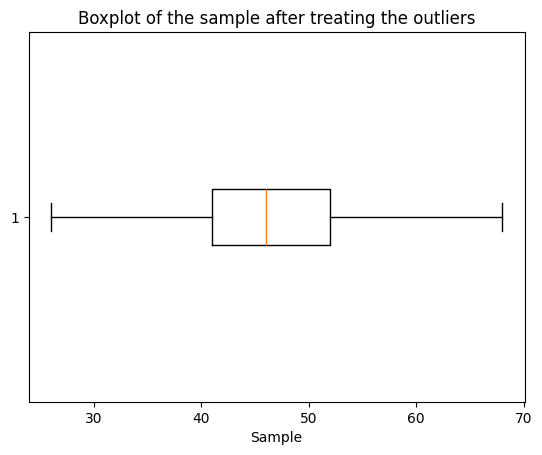

In [374]:
plt.boxplot(data_no_dup['Customer_Age'], vert=False)
plt.title("Boxplot of the sample after treating the outliers")
plt.xlabel("Sample")


In [375]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [376]:
def fix_missing_values(df):
    # Identify numerical and categorical columns
    num_cols = df.select_dtypes(exclude='object').columns
    cat_cols = df.select_dtypes(include='object').columns

    # Create transformers for numerical and categorical data
    num_transformer = IterativeImputer()
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols)
        ]
    )

    # Apply the transformations
    preprocessed_data = preprocessor.fit_transform(data_no_dup)

    # Convert the result back to a DataFrame (optional)
    preprocessed_df = pd.DataFrame(preprocessed_data)

    # Display the preprocessed DataFrame
    return preprocessed_df

In [377]:
X = data_no_dup.drop('Credit_Limit', axis=1)
y = data_no_dup['Credit_Limit']

X = fix_missing_values(X)


/home/kianoosh/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/impute/_base.py:597: UserWarning: Skipping features without any observed values: [13]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [378]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_train.shape

(6788, 36)

In [379]:
def select_features(X_train, y_train, X_test):
 fs = SelectKBest(score_func=mutual_info_regression, k=25)
 fs.fit(X_train, y_train)
 X_train_fs = fs.transform(X_train)

 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs


In [380]:

X_train_fs, X_test_fs, fs = select_features(X_train_pca, y_train, X_test_pca)

Feature 0: 0.328863
Feature 1: 0.067432
Feature 2: 0.038326
Feature 3: 0.025621
Feature 4: 0.037872
Feature 5: 0.060098
Feature 6: 0.007556
Feature 7: 0.081665
Feature 8: 0.017369
Feature 9: 0.012555
Feature 10: 0.023627
Feature 11: 0.029862
Feature 12: 0.031746
Feature 13: 0.056457
Feature 14: 0.043463
Feature 15: 0.047524
Feature 16: 0.049788
Feature 17: 0.065026
Feature 18: 0.027228
Feature 19: 0.052208
Feature 20: 0.005591
Feature 21: 0.038985
Feature 22: 0.000812
Feature 23: 0.000000
Feature 24: 0.016144
Feature 25: 0.001766
2


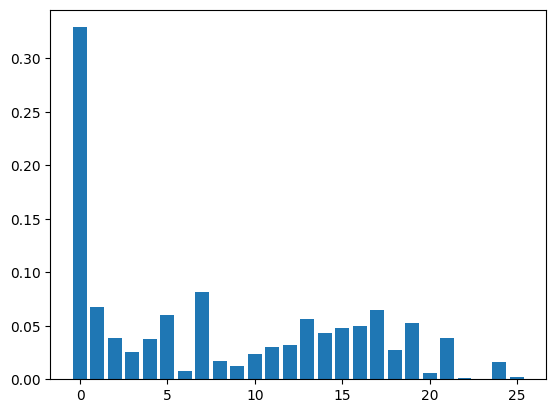

In [381]:
# what are scores for the features
ignr_cnt = 0
for i in range(len(fs.scores_)):
 if (fs.scores_[i] < 0.0015):
  ignr_cnt +=1
 print('Feature %d: %f' % (i, fs.scores_[i]))
print(ignr_cnt)
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [382]:
X_train_fs = np.array(X_train_fs) 
X_test_fs = np.array(X_test_fs) 

y_train = np.array(y_train) 
y_test = np.array(y_test) 



In [383]:
X_train_fs = torch.from_numpy(X_train_fs.astype(np.float32))
X_test_fs = torch.from_numpy(X_test_fs.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

X_train = torch.from_numpy(X_train.astype(np.float32))


y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

_, n_features = X_train_fs.shape




In [384]:
X_train_fs  = X_train_fs.to(device)
y_train = y_train.to(device)
X_train = X_train.to(device)

X_test_fs  = X_test_fs.to(device)
y_test = y_test.to(device)

In [385]:
class BankDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = (self.data[idx], self.targets[idx])
        return sample

In [386]:
dataset = BankDataset(X_train_fs, y_train)
dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=True)


In [387]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Model, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.leaky_reLu = nn.LeakyReLU()
        self.reLu = nn.ReLU()

        self.linear2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.dropout(x)

        out = self.linear1(out)
        out = self.leaky_reLu(out)
        out = self.linear2(out)
        # out = self.sigmoid(out)
        return out

In [388]:
class Model2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Model2, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(input_size, 25)

        
        self.linear2 = nn.Linear(25, 12)
        self.linear3 = nn.Linear(12, 1)
        self.linear4 = nn.Linear(12, 1)


        self.leaky_reLu = nn.LeakyReLU()
        self.reLu = nn.ReLU()

        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.dropout(x)
        out = self.linear1(out)
        out = self.leaky_reLu(out)
        out = self.linear2(out)
        out = self.leaky_reLu(out)
        out = self.linear3(out)
        # out = self.reLu(out)
        # out = self.linear4(out)
        # out = self.sigmoid(out)
        return out

In [389]:
model = Model2(36 , 13)
model = model.to(device)

n_features

25

In [390]:
num_epochs = 1000000
learning_rate = 0.01
criterion = nn.MSELoss()  ####################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lmbda = lambda epoch: 0.95

scheduler = MultiplicativeLR(optimizer, lr_lambda=lmbda)
lambda_reg = 0.1
loss = 0



for epoch in range(num_epochs):
    # Forward pass and loss
    # model.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)

    # TODO Validation
    # TODO Bath
    # TODO 2 for

    # # Compute L2 regularization term
    l2_reg = torch.tensor(0.)
    l2_reg = l2_reg.to(device)

    for param in model.parameters():
        l2_reg += torch.norm(param)
    
    # Add regularization term to loss
    loss += lambda_reg * l2_reg

    # Backward pass and update

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # zero grad before new step

    if (epoch+1) % 1000 == 0:
        print(f"epoch: {epoch+1}, loss = {loss.item():.4f} || "
              f"lr: {optimizer.state_dict()['param_groups'][0]['lr']:.7f}")
    if (epoch+1) % 10000 == 0 and epoch > 100000/2:
        scheduler.step()
    



epoch: 1000, loss = 15659520.0000 || lr: 0.0100000
epoch: 2000, loss = 14929703.0000 || lr: 0.0100000
epoch: 3000, loss = 14759649.0000 || lr: 0.0100000
epoch: 4000, loss = 14167304.0000 || lr: 0.0100000
epoch: 5000, loss = 14123411.0000 || lr: 0.0100000
epoch: 6000, loss = 14115822.0000 || lr: 0.0100000
epoch: 7000, loss = 14167435.0000 || lr: 0.0100000
epoch: 8000, loss = 14188723.0000 || lr: 0.0100000
epoch: 9000, loss = 14426698.0000 || lr: 0.0100000
epoch: 10000, loss = 14087226.0000 || lr: 0.0100000
epoch: 11000, loss = 14172886.0000 || lr: 0.0100000
epoch: 12000, loss = 14117862.0000 || lr: 0.0100000
epoch: 13000, loss = 14007906.0000 || lr: 0.0100000
epoch: 14000, loss = 14026899.0000 || lr: 0.0100000
epoch: 15000, loss = 13866248.0000 || lr: 0.0100000
epoch: 16000, loss = 14032403.0000 || lr: 0.0100000
epoch: 17000, loss = 13593400.0000 || lr: 0.0100000
epoch: 18000, loss = 13487386.0000 || lr: 0.0100000
epoch: 19000, loss = 13737044.0000 || lr: 0.0100000
epoch: 20000, loss = 

KeyboardInterrupt: 

In [393]:
from sklearn.metrics import mean_squared_error
with torch.no_grad():
    y_predicted = model(X_test)
    # y_predicted = np.array(y_predicted)
     
    MSE = mean_squared_error(y_predicted.cpu(), y_test.cpu())
MSE

11388481.0

In [281]:
loss

tensor(7073384., device='cuda:0', grad_fn=<AddBackward0>)

In [367]:
X_train_fs.shape

torch.Size([6788, 25])

In [392]:
X_test = torch.from_numpy(X_test.astype(np.float32))
X_test = X_test.to(device)
